In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from spacy.matcher import Matcher 
from spacy.tokens import Span

In [ ]:
!git clone https://github.com/ShubhamBhardwaj1971/COVID-19.git

fatal: destination path 'COVID-19' already exists and is not an empty directory.


In [ ]:
sentences_dataframe = pd.read_csv('/content/COVID-19/Sample_Files/Spike_Protein_Details.csv')

In [ ]:
def extract_root(sentence):   
    doc = nlp(sentence)
    matcher = Matcher(nlp.vocab)
    root_pattern = [{'DEP':'ROOT'},             
               {'DEP':'prep','OP':"?"},            
               {'DEP':'agent','OP':"?"},              
               {'POS':'ADJ','OP':"?"}
               ]    
    matcher.add("root_matcher", None, root_pattern)    
    matches = matcher(doc)  
    k = len(matches) - 1   
    span = doc[matches[k][1]:matches[k][2]]    
    return(span.text)

In [ ]:
def get_entities(sent):
  ent1 = ""
  ent2 = ""
  prv_tok_dep = "" 
  prv_tok_text = "" 
  prefix = ""
  modifier = ""
  for tok in nlp(sent):
    if tok.dep_ != "punct":
      if tok.dep_ == "compound":
        prefix = tok.text
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [ ]:
root_words = [] 
for item in sentences_dataframe["sentence"]:
    root_words.append(extract_root(item))

In [ ]:
root_words

['are',
 'provide',
 'is',
 'divided into',
 'believed',
 'releases',
 'provide',
 'contains',
 'described as',
 'contains',
 'include',
 'is',
 'plays',
 'covered in',
 'packed',
 'expressed on',
 'initiated by',
 'constitutes',
 'shielded',
 'present',
 'predicted']

In [ ]:
entities = [] 
for item in sentences_dataframe["sentence"]:
    entities.append(get_entities(item))

In [ ]:
entities

[['Coronaviruses', 'SARS CoV-2'],
 ['derived  set', 'viral  RNA'],
 ['which', 'initial host cell'],
 ['where  we', 'S1  subunits'],
 ['likely TMPRSS site', 'infection'],
 ['fusion which', 'host cell fusion'],
 ['atomic SARS CoV-2 which', 'multiple  domains'],
 ['interaction', 'ACE2  host'],
 ['loaded fusion it', 'viral cell membranes'],
 ['It', 'FP'],
 ['S2 that', 'TM heptad stalk'],
 ['S that', 'extensive  Figure'],
 ['Protein glycosylation', 'viral fusion proteins'],
 ['accessible surface area', 'entirely N glycans'],
 ['densely  they', 'than  protein'],
 ['biological  roles', 'inextricably envelope nature'],
 ['molecular cell surface which', 'N glycan N epitopes'],
 ['dense  coating', 'immune  system'],
 ['quite  virus', 'Contrary HIV-1 Env'],
 ['Furthermore SARS CoV', 'oligomannose complex N type'],
 ['least N glycosylation 2', 'O glycosylation Figures']]

In [ ]:
# extract subject
source = [i[0] for i in entities]

# extract object
target = [i[1] for i in entities]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':root_words})

In [ ]:
kg_df

,source,target,edge
0,Coronaviruses,SARS CoV-2,are
1,derived set,viral RNA,provide
2,which,initial host cell,is
3,where we,S1 subunits,divided into
4,likely TMPRSS site,infection,believed
5,fusion which,host cell fusion,releases
6,atomic SARS CoV-2 which,multiple domains,provide
7,interaction,ACE2 host,contains
8,loaded fusion it,viral cell membranes,described as
9,It,FP,contains


In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

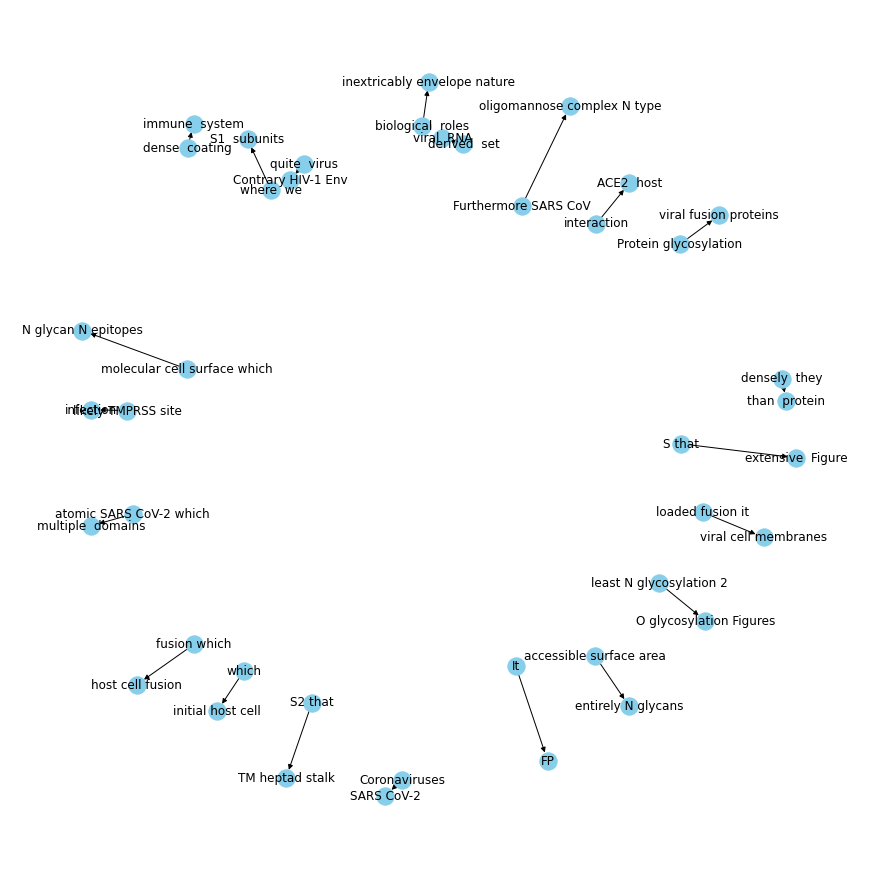

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()